In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns


from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

from pathlib import Path
import os.path


from sklearn.metrics import classification_report, confusion_matrix


e:\minicondareal\envs\tensormain\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:

import sys

import pandas as pd

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.10.0

Python 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [4]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)

    # Seed value for NumPy
    np.random.seed(seed)

    # Seed value for Python's random library
    random.seed(seed)

    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-02-18 13:28:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

     0K ..........                                            100% 16.2M=0.001s

2024-02-18 13:28:53 (16.2 MB/s) - 'helper_functions.py' saved [10246/10246]



In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [7]:
# Walk through each directory
dataset = r'E:\ClothesA'
walk_through_dir(dataset)

There are 9 directories and 0 images in 'E:\ClothesA'.
There are 0 directories and 240 images in 'E:\ClothesA\Full Pant'.
There are 0 directories and 240 images in 'E:\ClothesA\Full Sleeve Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Full Sleeve T-Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Half Pant'.
There are 0 directories and 240 images in 'E:\ClothesA\Half Sleeve Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Half Sleeve T-Shirt'.
There are 0 directories and 240 images in 'E:\ClothesA\Hoodie'.
There are 0 directories and 240 images in 'E:\ClothesA\Jacket'.
There are 0 directories and 240 images in 'E:\ClothesA\Sweater'.


In [11]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths =   list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [12]:
label_counts = image_df['Label'].value_counts()
print(label_counts)

Label
Full Pant              240
Full Sleeve Shirt      240
Full Sleeve T-Shirt    240
Half Pant              240
Half Sleeve Shirt      240
Half Sleeve T-Shirt    240
Hoodie                 240
Jacket                 240
Sweater                240
Name: count, dtype: int64


C:\Users\mehra\AppData\Local\Temp\ipykernel_9640\2361829875.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\mehra\AppData\Local\Temp\ipykernel_9640\2361829875.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


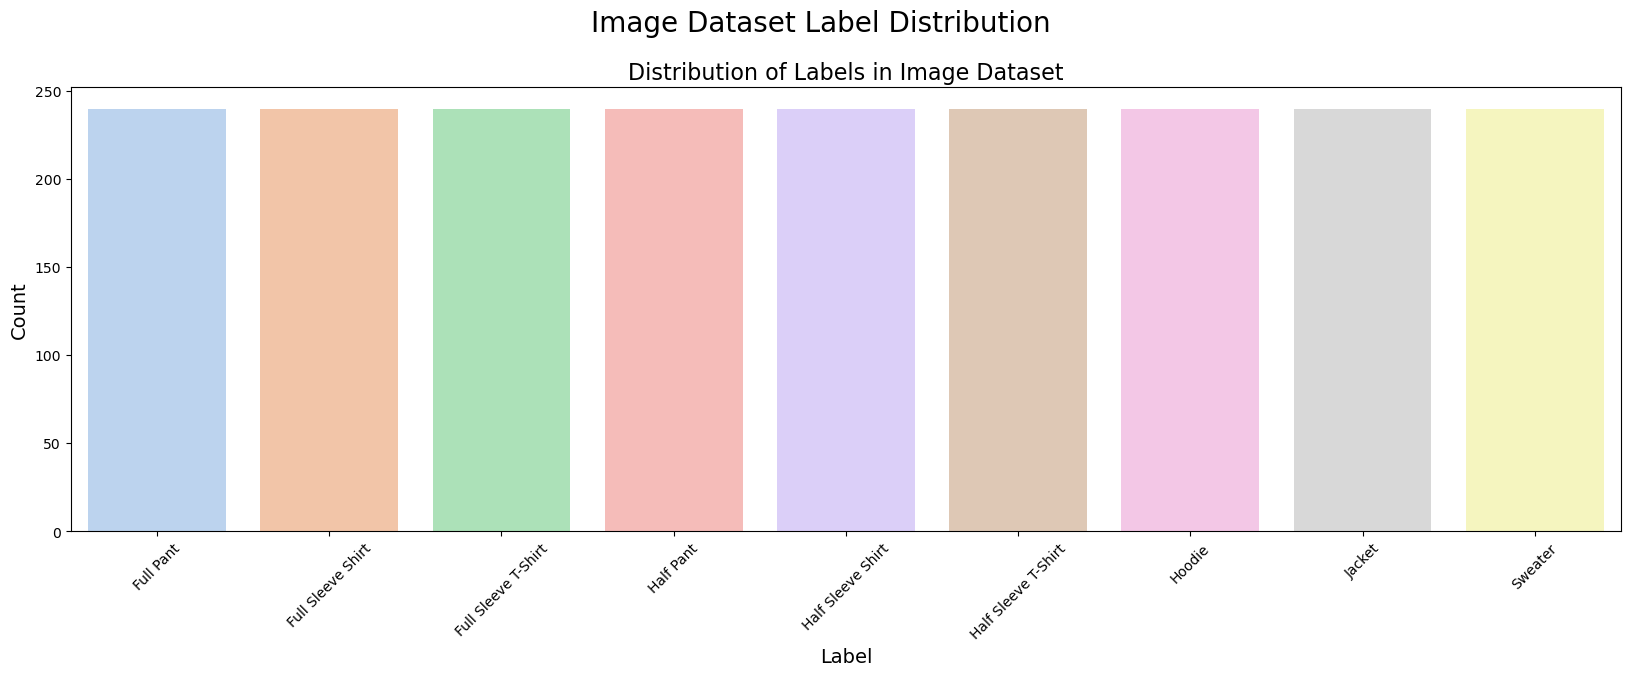

In [13]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

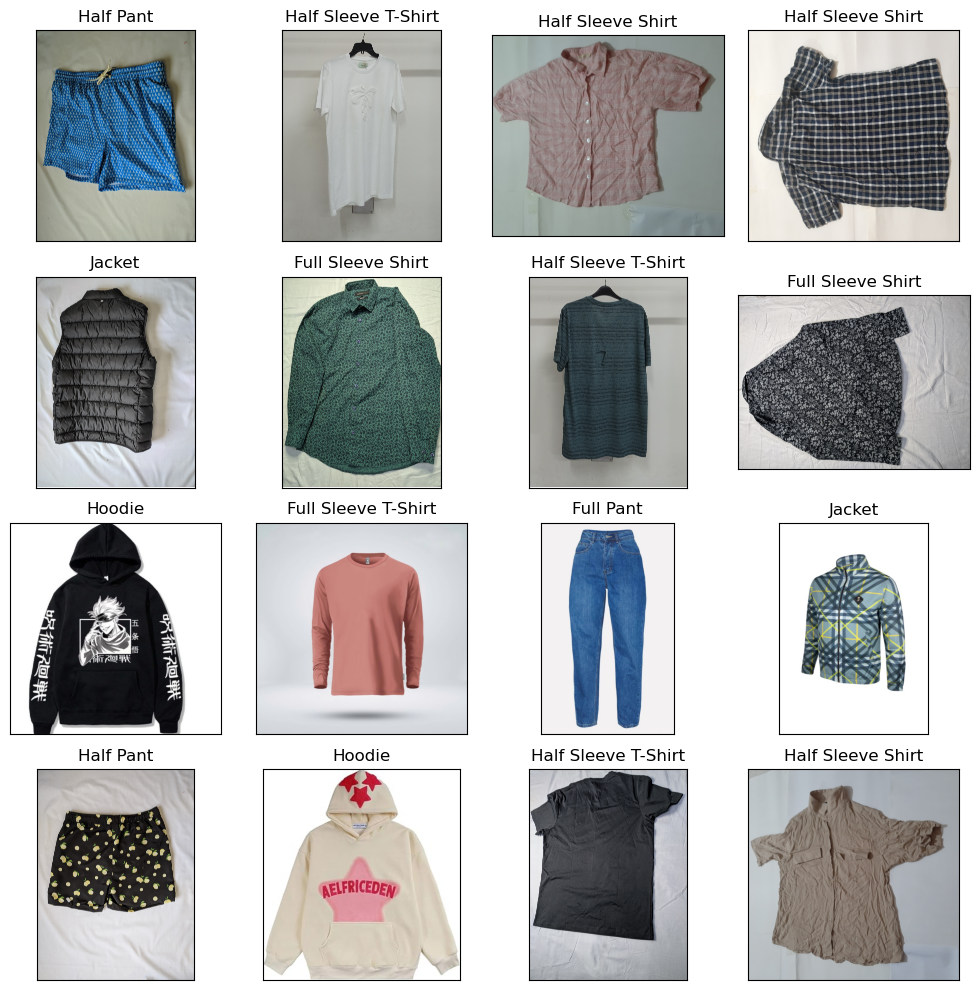

In [14]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [15]:
image_df

Filepath      Label
0       E:\ClothesA\Full Pant\Full Pant (1).jpg  Full Pant
1      E:\ClothesA\Full Pant\Full Pant (10).jpg  Full Pant
2     E:\ClothesA\Full Pant\Full Pant (100).jpg  Full Pant
3     E:\ClothesA\Full Pant\Full Pant (101).jpg  Full Pant
4     E:\ClothesA\Full Pant\Full Pant (102).jpg  Full Pant
...                                         ...        ...
2155         E:\ClothesA\Hoodie\Hoodie (9).jpeg     Hoodie
2156         E:\ClothesA\Jacket\Jacket (1).jpeg     Jacket
2157       E:\ClothesA\Jacket\Jacket (238).jpeg     Jacket
2158       E:\ClothesA\Jacket\Jacket (239).jpeg     Jacket
2159         E:\ClothesA\Jacket\Jacket (4).jpeg     Jacket

[2160 rows x 2 columns]

In [16]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    validation_split=0.2,
)
#keras.applications.resnet_v2.preprocess_input
#keras.applications.densenet.preprocess_input
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
)

In [18]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'

)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1383 validated image filenames belonging to 9 classes.
Found 345 validated image filenames belonging to 9 classes.
Found 432 validated image filenames belonging to 9 classes.


In [19]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name="data_augmentation")

In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.ResNet152V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [21]:
# Create checkpoint callback
checkpoint_path = "clothes_resnet152V2"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [22]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
#RESNET

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "clothes_resnet152V2_training_logs"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/clothes_resnet152V2_training_logs/20240218-135020
Epoch 1/100
44/44 [==============================] - 205s 4s/step - loss: 8.3416 - accuracy: 0.1128 - val_loss: 4.4474 - val_accuracy: 0.1565 - lr: 1.0000e-05
Epoch 2/100
44/44 [==============================] - 153s 3s/step - loss: 6.3396 - accuracy: 0.1280 - val_loss: 3.3868 - val_accuracy: 0.1768 - lr: 1.0000e-05
Epoch 3/100
44/44 [==============================] - 152s 3s/step - loss: 5.2109 - accuracy: 0.1786 - val_loss: 2.8065 - val_accuracy: 0.2290 - lr: 1.0000e-05
Epoch 4/100
44/44 [==============================] - 148s 3s/step - loss: 4.5157 - accuracy: 0.2111 - val_loss: 2.4141 - val_accuracy: 0.2986 - lr: 1.0000e-05
Epoch 5/100
44/44 [==============================] - 148s 3s/step - loss: 4.0691 - accuracy: 0.2292 - val_loss: 2.0922 - val_accuracy: 0.3536 - lr: 1.0000e-05
Epoch 6/100
44/44 [==============================] - 149s 3s/step - loss: 3.4274 - accuracy: 0.2871 - val_lo

In [25]:
model.save("clothes_resnet152V2_run1.h5")

In [56]:
# Load the Keras model (.h5)
model = tf.keras.models.load_model('clothes_resnet152V2_run1.h5')

# Convert the Keras model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to disk
with open('clothes_resnet152V2_run1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\mehra\AppData\Local\Temp\tmpkyipw3_b\assets


INFO:tensorflow:Assets written to: C:\Users\mehra\AppData\Local\Temp\tmpkyipw3_b\assets


In [26]:
training_history = history.history

In [27]:
with open('metrics.txt', 'w') as file:
    file.write("Training Accuracy: {}\n".format(training_history['accuracy']))
    file.write("Validation Accuracy: {}\n".format(training_history['val_accuracy']))
    file.write("Training Loss: {}\n".format(training_history['loss']))
    file.write("Validation Loss: {}\n".format(training_history['val_loss']))

In [34]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.41376
Test Accuracy: 87.96%


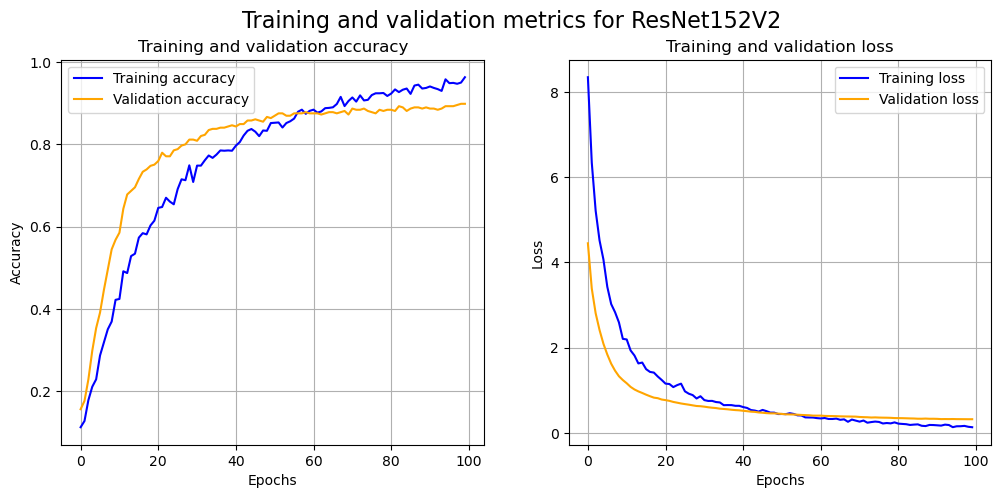

In [43]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training Accuracy and Validation Accuracy
ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot Training Loss and Validation Loss
ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'orange', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Overall title for the entire figure
fig.suptitle('Training and validation metrics for ResNet152V2', fontsize=16)
plt.show()

In [35]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

14/14 [==============================] - 22s 2s/step
The first 5 predictions: ['Half Sleeve Shirt', 'Full Sleeve T-Shirt', 'Half Sleeve Shirt', 'Half Sleeve Shirt', 'Half Pant']


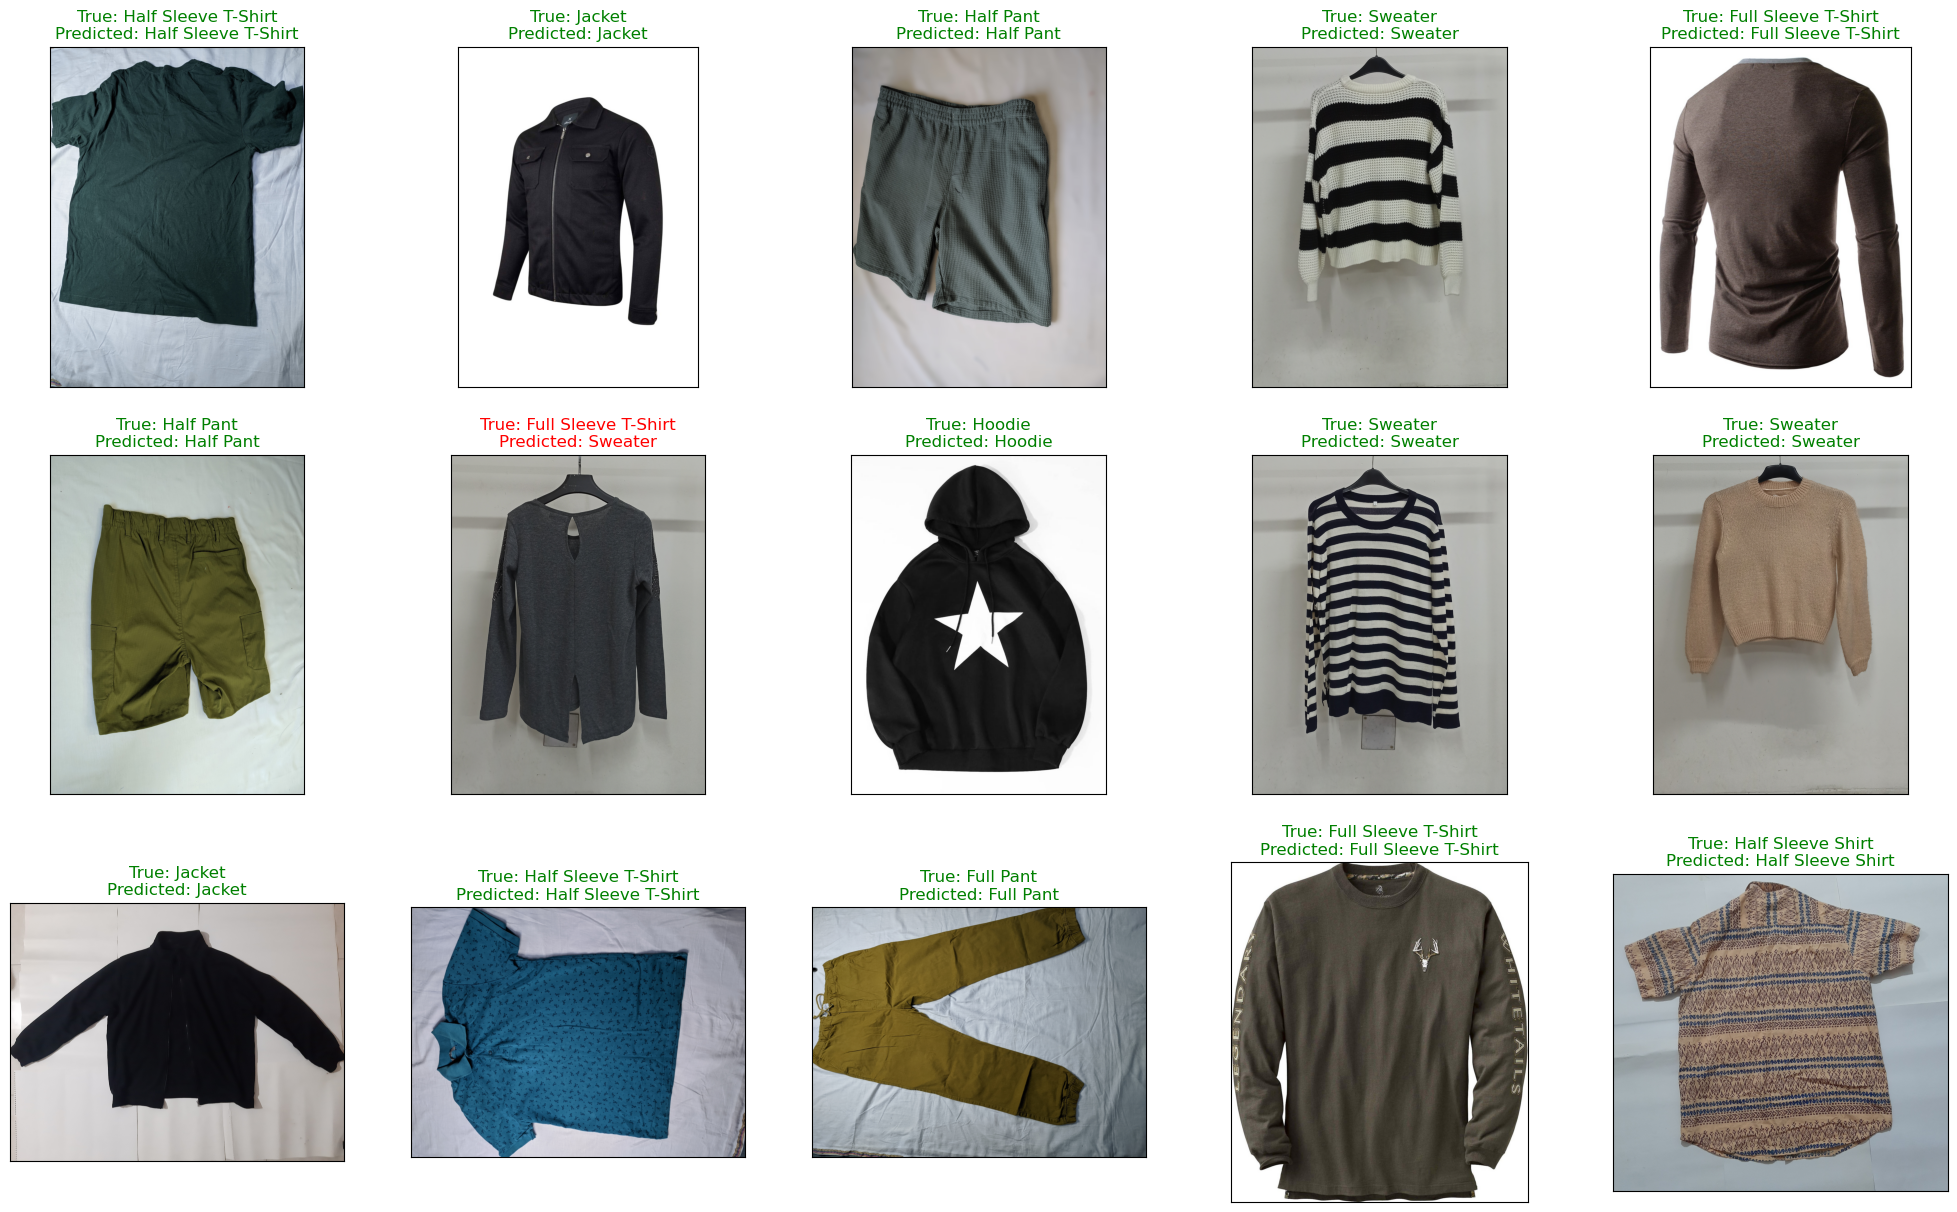

<Figure size 640x480 with 0 Axes>

In [48]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [37]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                     precision    recall  f1-score   support

          Full Pant       1.00      0.89      0.94        46
  Full Sleeve Shirt       0.85      0.84      0.84        55
Full Sleeve T-Shirt       0.88      0.81      0.84        47
          Half Pant       0.94      1.00      0.97        45
  Half Sleeve Shirt       0.87      0.84      0.85        49
Half Sleeve T-Shirt       0.91      0.93      0.92        45
             Hoodie       0.84      0.84      0.84        45
             Jacket       0.78      0.89      0.83        47
            Sweater       0.87      0.89      0.88        53

           accuracy                           0.88       432
          macro avg       0.88      0.88      0.88       432
       weighted avg       0.88      0.88      0.88       432



In [38]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score    support
Full Pant             1.000000  0.891304  0.942529   46.00000
Full Sleeve Shirt     0.851852  0.836364  0.844037   55.00000
Full Sleeve T-Shirt   0.883721  0.808511  0.844444   47.00000
Half Pant             0.937500  1.000000  0.967742   45.00000
Half Sleeve Shirt     0.872340  0.836735  0.854167   49.00000
Half Sleeve T-Shirt   0.913043  0.933333  0.923077   45.00000
Hoodie                0.844444  0.844444  0.844444   45.00000
Jacket                0.777778  0.893617  0.831683   47.00000
Sweater               0.870370  0.886792  0.878505   53.00000
accuracy              0.879630  0.879630  0.879630    0.87963
macro avg             0.883450  0.881233  0.881181  432.00000
weighted avg          0.882155  0.879630  0.879764  432.00000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 15), text_size=10, norm=False, savefig=True):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels."""
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    sorted_labels = sorted(labels)
    # Label the axes
    ax.set(title="Confusion Matrix of DenseNet201",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),  # create enough axis slots for each class
       yticks=np.arange(n_classes),
       xticklabels=sorted_labels,  # use the sorted labels
       yticklabels=sorted_labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("E:/Web/HTMLSection3/400C/Main/DensetNet201/confusion_matrix.png")

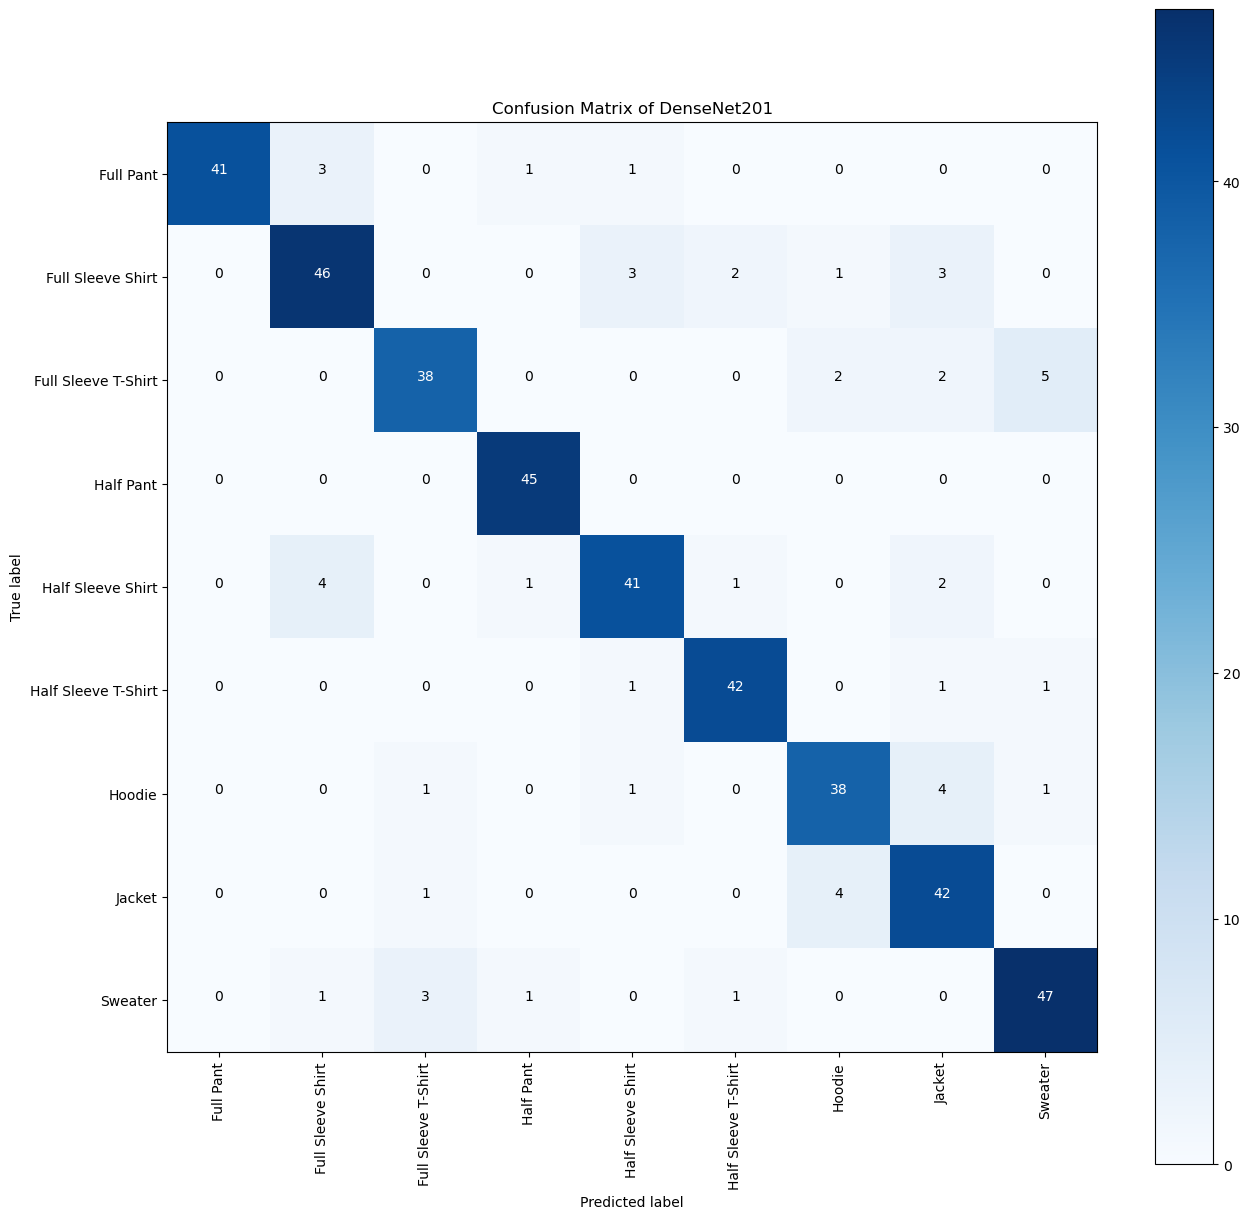

In [40]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [51]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    

preprocess_input = tf.keras.applications.efficientnet.preprocess_input
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

last_conv_layer_name = "conv5_block3_out"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

C:\Users\mehra\AppData\Local\Temp\ipykernel_9640\1640930519.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


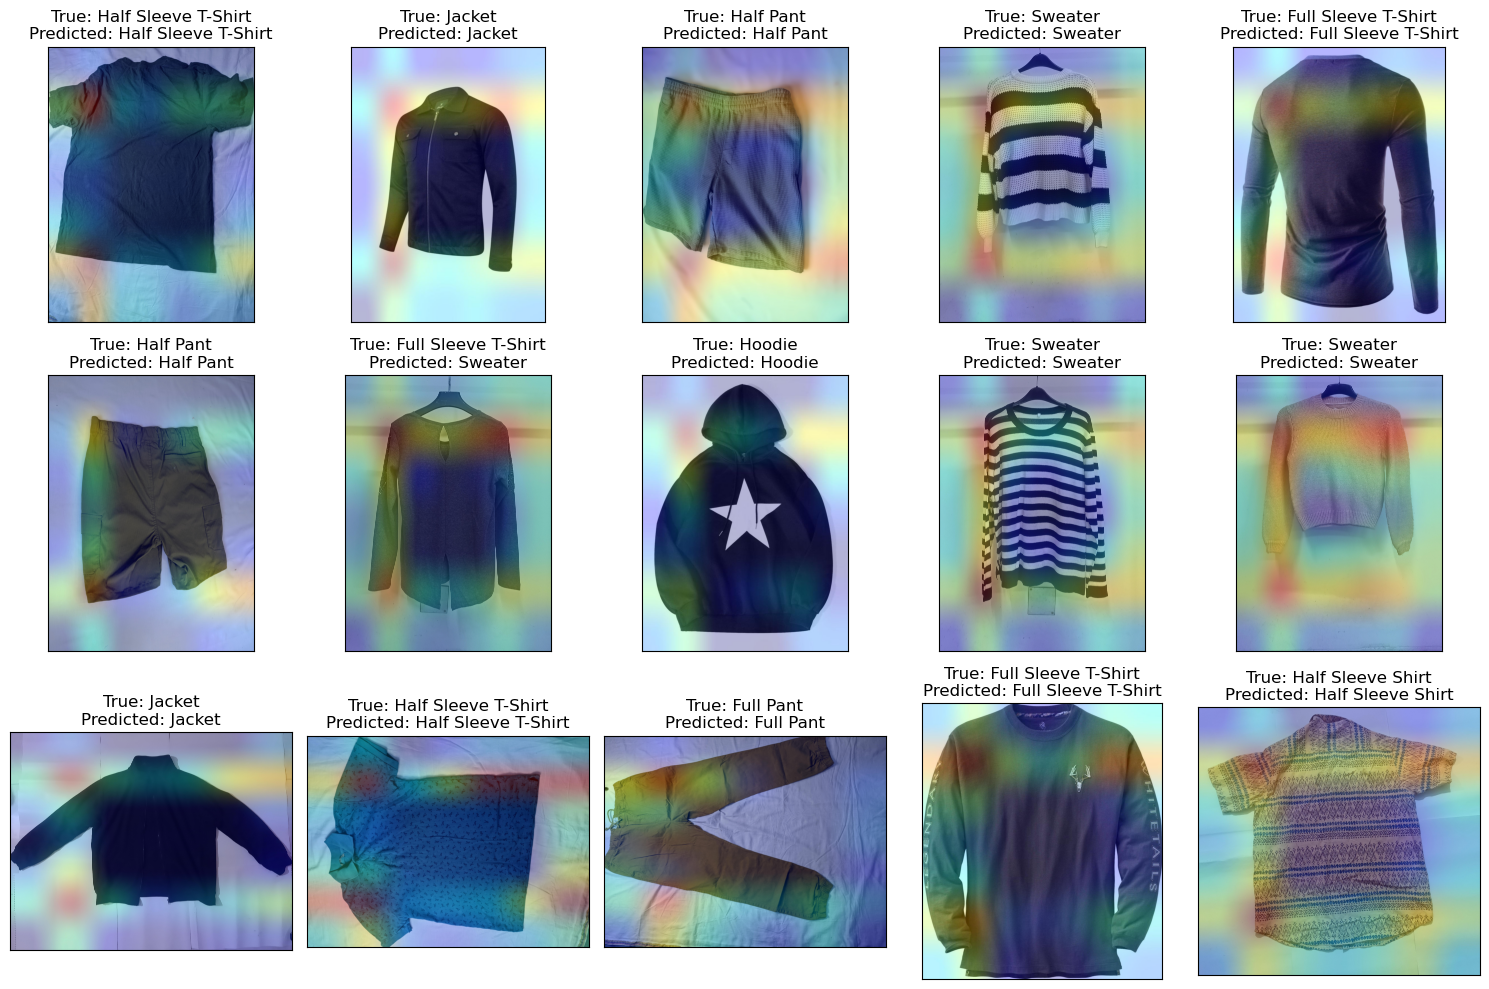

In [52]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

In [53]:
import pickle

In [54]:
with open('model_resnet152v2.pkl', 'wb') as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://ca79b4d2-c96d-4470-bbb6-5b7361cab168/assets


INFO:tensorflow:Assets written to: ram://ca79b4d2-c96d-4470-bbb6-5b7361cab168/assets
